*Debéis decidir qué problema queréis abordar lo antes posible y comunicar vuestra elección (por correo electrónico) enviando la evaluación preliminar del problema a bejar@cs.upc.edu no más tarde de 24 de Octubre. Indicad también todoslos nombres de los miembros del grupo.*

# **Informe Previ**

---

Juli Sahun Montejano

Victor Pla Sanchis

### Descripció del problema


---
Hem decidit abarcar un problema de classificació binària. Donat un conjunt de dades, estudiar-les i analitzar-les per poder aplicar un model predictor de classificació que ens separi dues classes significativament variades.

### Descripció del dataset


---
El dataset ha de complir:

El dataset que hem escollit recull informacio sobre carteres de ethereum on algunes de les cuals son fraudulentes, el nostre objectiu sera entrenar un model que pugui predir basant-se amb la resta de dades, quins perfils son potencialment fraudulents. Acountinuacio, enumerem els camps del nostre dataset:

* address : string
* flag : boolean
* min/max/avgTimeBetweeSentTnx : float
* min/max/avgTimeBetweeRecTnx : float
* lifetime : float
* sentTransactions : float
* receivedTransactions : float
* createdContracts : float
* numUniqSentAddress : float
* min/max/avgValReceived : float
* totalTransactions : float
* totalEtherSent : float
* totalEtherReceived : float
* totalEtherSentContracts : float
* totalEtherBalance : float
* activityDays : float
* dailyMax : float
* ratioRecSent : float
* ratioSentTotal : float
* ratioRecTotal : float
* giniSent : float
* giniRec : float
* txFreq : float
* stdBalanceEth : float



In [1]:
# !pip3 install pandas --upgrade --user --quiet
# !pip3 install numpy --upgrade --user --quiet
# !pip3 install scipy --upgrade --user --quiet
# !pip3 install scikit-learn --upgrade --user --quiet
# !pip3 install missingno --upgrade --user --quiet
# !pip3 install apafib --upgrade --user --quiet
# !pip3 install yellowbrick
# !pip3 install scikit-optimize
# !pip3 install matplotlib==3.6.0 --user --quiet
# !pip3 install pyyaml
# !pip3 install lime

In [2]:


import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas import read_csv
import matplotlib as mpl

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.metrics import  ConfusionMatrixDisplay,\
                  classification_report,  RocCurveDisplay, \
                    accuracy_score, f1_score, precision_score, recall_score


import lime
import lime.lime_tabular
from sklearn.model_selection import GridSearchCV

from yellowbrick.target.feature_correlation import feature_correlation
from sklearn.decomposition import PCA
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.precision', 3)

In [3]:
def save_results(clf, X_test, y_test, nclf, df):
    df.loc[nclf,'test acc'] = accuracy_score(y_test, clf.predict(X_test))
    df.loc[nclf,'precision score (W)'] = precision_score(y_test, clf.predict(X_test), average='weighted')
    df.loc[nclf,'recall score (W)'] = recall_score(y_test, clf.predict(X_test), average='weighted')
    df.loc[nclf,'f1 score (W)'] = f1_score(y_test, clf.predict(X_test), average='weighted')
    return df

results_df_lineal = pd.DataFrame()
results_df_no_lineal = pd.DataFrame()

niter = 15
cv = 5

### Descàrrega del dataset

---

In [4]:
#https://www.kaggle.com/datasets/gescobero/ethereum-fraud-dataset
data = pd.read_csv("./data/eth_illicit_features.csv")
print("Filas:",data.shape[0])
print("Columnas:",data.shape[1])

Filas: 12146
Columnas: 34


### Analisis del dataset

---

In [5]:
data.head()

,address,flag,minTimeBetweenSentTnx,maxTimeBetweenSentTnx,avgTimeBetweenSentTnx,minTimeBetweenRecTnx,maxTimeBetweenRecTnx,avgTimeBetweenRecTnx,lifetime,sentTransactions,receivedTransactions,createdContracts,numUniqSentAddress,numUniqRecAddress,minValSent,maxValSent,avgValSent,minValReceived,maxValReceived,avgValReceived,totalTransactions,totalEtherSent,totalEtherReceived,totalEtherSentContracts,totalEtherBalance,activityDays,dailyMax,ratioRecSent,ratioSentTotal,ratioRecTotal,giniSent,giniRec,txFreq,stdBalanceEth
0,0xd0cc2b24980cbcca47ef755da88b220a82291407,1,0.0,2.387e+06,5.808e+04,8.900e+01,1.501e+09,7.148e+07,46,66,21,0,47,17,0.0,183.0,5.559,0.019,266.000,17.486,87,366.921,367.213,0.0,0.292,10,60,0.313,0.750,0.239,0.969,0.889,1.891,147.701
1,0x4cdc1cba0aeb5539f2e0ba158281e67e0e54a9b1,1,0.0,0.000e+00,0.000e+00,3.021e+06,1.503e+09,7.529e+08,35,0,2,0,0,2,0.0,0.0,0.000,0.004,0.010,0.007,2,0.000,0.014,0.0,0.014,2,1,2.000,0.000,0.667,0.000,0.238,0.057,0.005
2,0x00e01a648ff41346cdeb873182383333d2184dd1,1,37.0,2.511e+07,1.710e+06,0.000e+00,1.500e+09,6.821e+07,299,15,22,0,13,21,0.0,25.0,13.330,0.425,49.999,9.101,37,199.950,200.216,0.0,0.266,14,16,1.375,0.395,0.579,0.465,0.614,0.124,52.130
3,0x858457daa7e087ad74cdeeceab8419079bc2ca03,1,0.0,6.425e+05,1.576e+04,0.000e+00,1.500e+09,1.353e+07,36,109,111,0,54,104,0.0,680.0,14.959,0.010,193.500,14.690,220,1630.570,1630.577,0.0,0.007,36,67,1.009,0.493,0.502,0.958,0.794,6.111,233.689
4,0x240e125c20a4cc84bd6e7f8d1fd07aff4c06d43d,1,0.0,0.000e+00,0.000e+00,3.894e+03,1.500e+09,3.751e+08,82,1,4,0,1,4,1.9,1.9,1.900,0.002,1.000,0.476,5,1.900,1.902,0.0,0.002,3,3,2.000,0.167,0.667,0.000,0.407,0.061,0.758


Eliminem la columna $address$ ja que no ens aporta cap informacio

In [6]:
data.drop(columns=['address'], inplace=True)
data.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
flag,12146.0,4.240e-01,4.942e-01,0.000e+00,0.000e+00,0.000e+00,1.000e+00,1.000e+00
minTimeBetweenSentTnx,12146.0,2.649e+04,7.168e+05,0.000e+00,0.000e+00,0.000e+00,8.000e+01,6.199e+07
maxTimeBetweenSentTnx,12146.0,4.271e+07,2.510e+08,0.000e+00,0.000e+00,2.042e+05,1.845e+06,1.658e+09
avgTimeBetweenSentTnx,12146.0,3.649e+06,4.121e+07,0.000e+00,0.000e+00,1.491e+04,1.391e+05,8.291e+08
minTimeBetweenRecTnx,12146.0,2.499e+05,3.404e+06,0.000e+00,0.000e+00,4.800e+01,7.148e+02,1.509e+08
maxTimeBetweenRecTnx,12146.0,1.162e+09,7.159e+08,0.000e+00,2.795e+06,1.579e+09,1.641e+09,1.658e+09
avgTimeBetweenRecTnx,12146.0,1.602e+08,2.329e+08,0.000e+00,8.565e+04,4.777e+07,2.192e+08,8.310e+08
lifetime,12146.0,1.917e+02,3.000e+02,1.000e+00,9.000e+00,6.800e+01,2.510e+02,2.293e+03
sentTransactions,12146.0,5.174e+02,1.875e+03,0.000e+00,1.000e+00,6.000e+00,7.000e+01,1.000e+04
receivedTransactions,12146.0,6.784e+02,2.254e+03,0.000e+00,3.000e+00,1.100e+01,5.500e+01,1.000e+04


Separem les dades en el conjunt predictor i el conjunt objectiu. Aprofitem tambe per normalitzar les dades, ja que tenen rangs de valors molt diferents

In [7]:
drops = []
for val, key in zip(data.describe(include='all').T['50%'], data.columns):
    if val == 0.0:
        drops.append(key)
drops.remove('flag')
data.drop(columns=drops, inplace=True)

In [8]:
X= data.iloc[:,1:]
y= data.loc[:,'flag'].copy()
target_names=['Normal', 'Fraudulent']

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train_n = scaler.fit_transform(X_train)
X_test_n = scaler.transform(X_test)

Podem representar la distribucio de les variables per veure si alguna segueix algun comportament especific:

In [11]:
''' aixo esta comentat perque triga molt en execurar-se, pero es una manera de veure la distribucio de les dades'''

# #ejecutar con matplotlib 3.6.0!! https://github.com/mwaskom/seaborn/issues/3072

# fig, axes = plt.subplots(14,2,figsize=(15,50))
# X_train_nr = X_train_n.round(3)
# X_test_nr = X_test_n.round(3)
# X_train_frame = pd.DataFrame(X_train_nr)
# X_train_frame.columns=X.columns
# for i, c in enumerate(X.columns):
#     ax = axes.reshape(-1)[i]
#     if X_train_frame[c].dtype.kind == 'O':
#         a = sns.countplot(x=c,data=X_train_frame,ax=ax)
#     else:
#         b = sns.histplot(x=c,data=X_train_frame,ax=ax)
# plt.tight_layout()

' aixo esta comentat perque triga molt en execurar-se, pero es una manera de veure la distribucio de les dades'

Podem representar en un _Heatmap_ la correlacio entre les variables

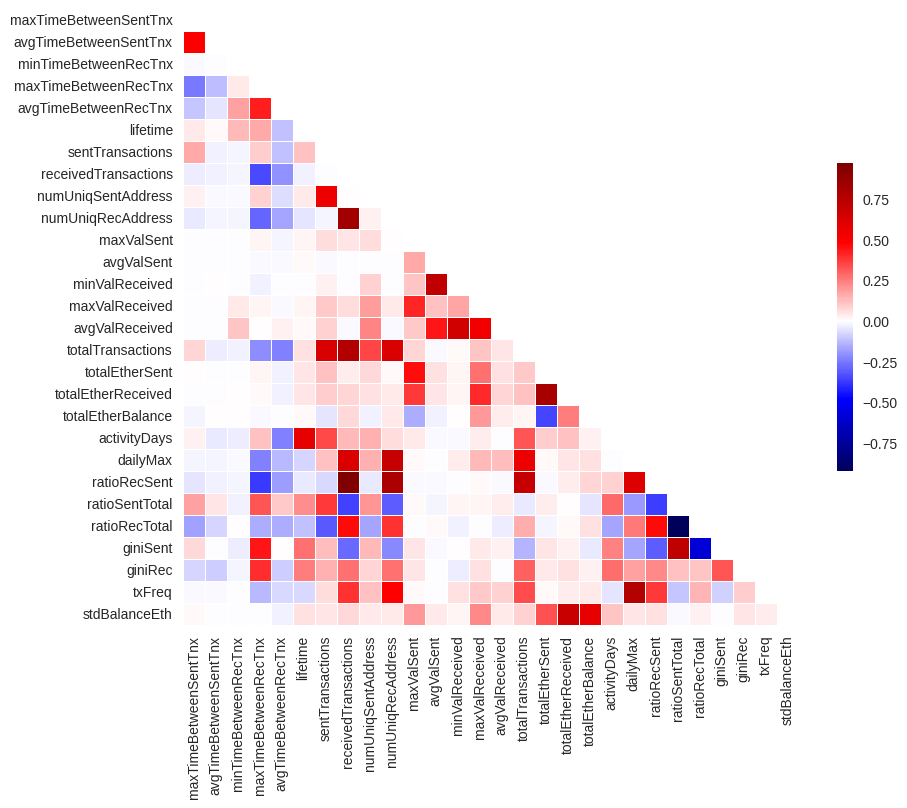

In [12]:
corr = X_train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

En Aquest grafic podem veure la relacio de cada una de les variables amb la variable objectiu, en aquest cas, $flag$

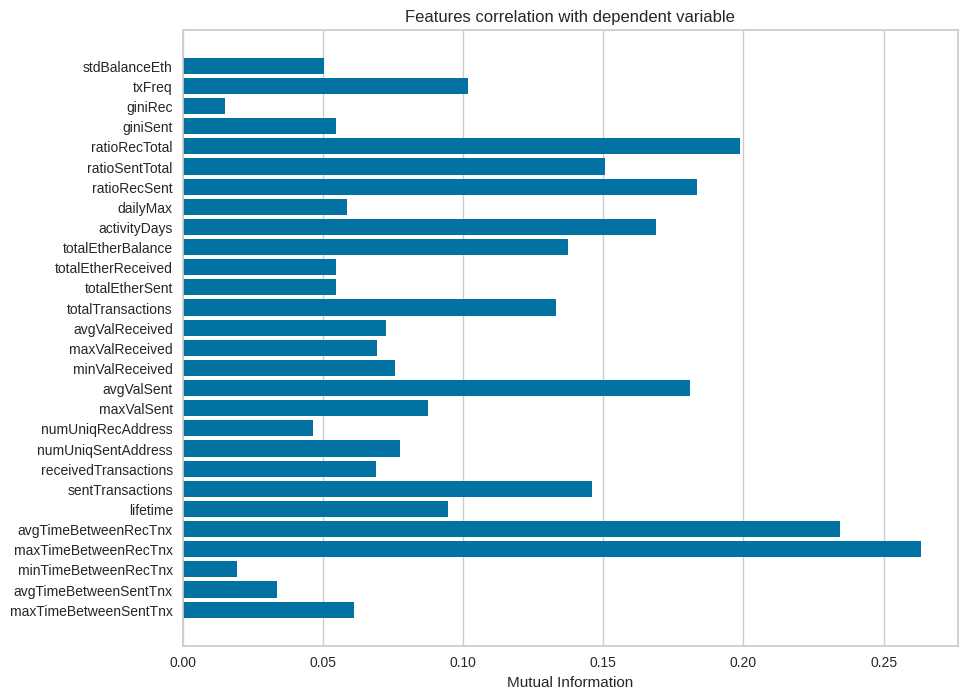

In [13]:
plt.figure(figsize=(10,8))
visualizer = feature_correlation(X_train, y_train, labels=list(X_train.columns),method='mutual_info-classification');

In [14]:
pca = PCA().fit(X_train)

Calculant el PCA ja ens donem compte que no sera una feina facil, no es fins prop de la 15 component, on podem explicar un 80% de la variancia de les dades

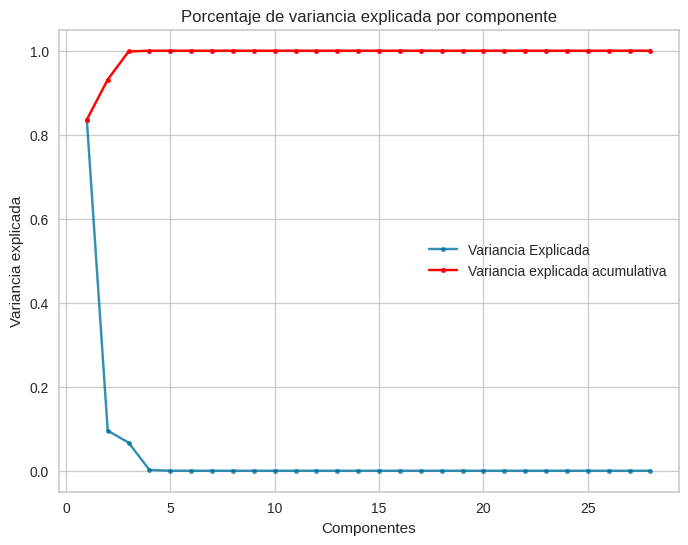

In [15]:
fig = plt.figure(figsize=(8,6));
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),pca.explained_variance_ratio_ ,alpha=0.8,marker='.',label="Variancia Explicada");
y_label = plt.ylabel('Variancia explicada');
x_label = plt.xlabel('Componentes');
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         np.cumsum(pca.explained_variance_ratio_),
         c='red',marker='.',
         label="Variancia explicada acumulativa");
plt.legend();
plt.title('Porcentaje de variancia explicada por componente');

Les dues primeres components del PCA expliquen la misera variança del 25-30%. Aixi doncs, es d'esperar que no poguem visualitzar cap tipus de resultat satisfactori

<AxesSubplot: >

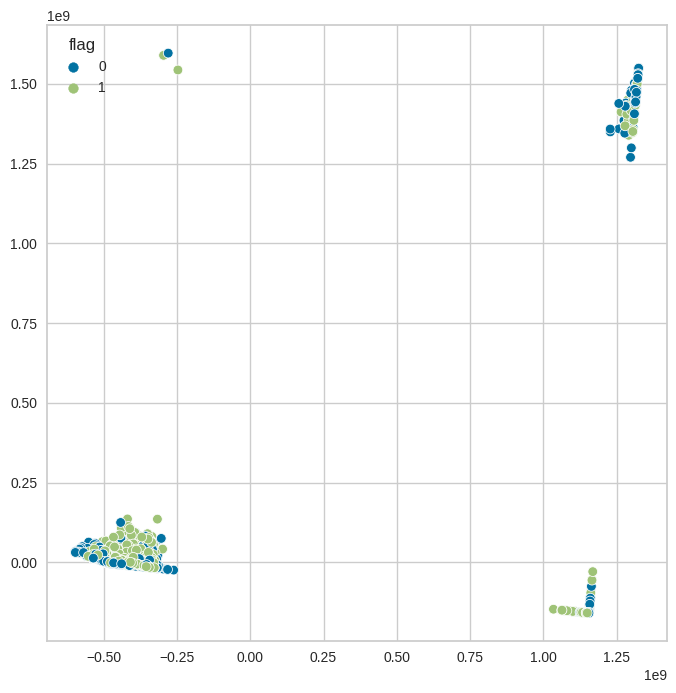

In [16]:
X_trans = pca.transform(X_train)
plt.figure(figsize=(8,8));
sns.scatterplot(x=X_trans[:,0], y=X_trans[:,1], hue=y_train)

### Models linials

Probem de clasificar les dades fent servir un model d'Analisis de Discriminacio Lineal

Obtenim el resultat de la mitjana de les 10 validacions encreuades

In [17]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
print(np.mean(cross_val_score(lda,X_train,y_train,cv=10)))

0.7648996195121657


Com podem veure, el resultat obtinugt esta lluny de ser bo, pero no es tant dolent com en un principi ens podriem esperar/

Podem veure el _clasification report_ del model par veure en mes detall els seus resultats:

In [18]:
lda.fit(X_train, y_train)
print(classification_report(lda.predict(X_test), y_test,target_names=target_names))
results_df_lineal = save_results(lda, X_test, y_test, 'LDA', results_df_lineal)

              precision    recall  f1-score   support

      Normal       0.77      0.82      0.79      2152
  Fraudulent       0.77      0.71      0.74      1857

    accuracy                           0.77      4009
   macro avg       0.77      0.77      0.77      4009
weighted avg       0.77      0.77      0.77      4009



Mirant la matriu de confusio veiem que, aproximadament, un 20% dels casos fraudulents els classifiquem com a normals, i un 20% dels casos normals els classifiquem com a fraudulents

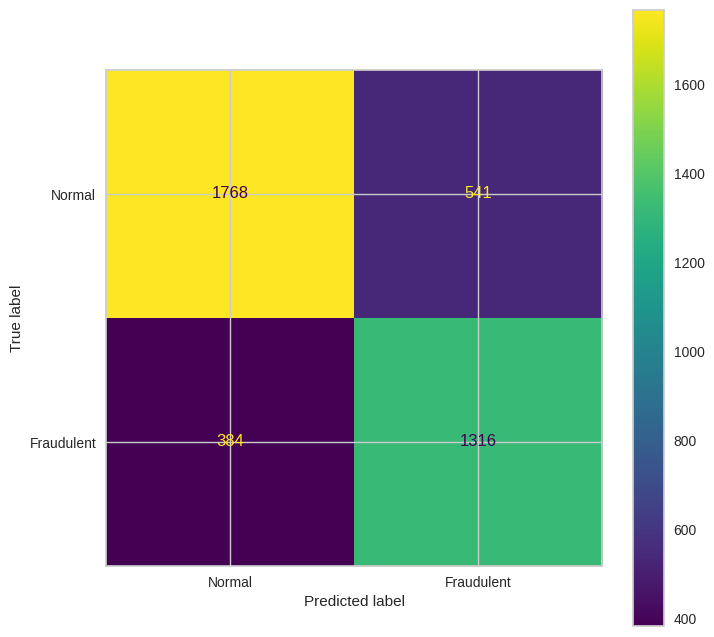

In [19]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(lda, X_test,y_test, display_labels=target_names, ax=plt.subplot());

Podem veure la curva ROC per veure en mes detall quina proporcio de casos fraudulents clasifiquem com a tal, en relacio els casos totals que clasifiquem com a fraudulents.

Com podem veure, es necessari prop d'un 60% de falsos positius per tenir un resultat acceptable de vertaders positius

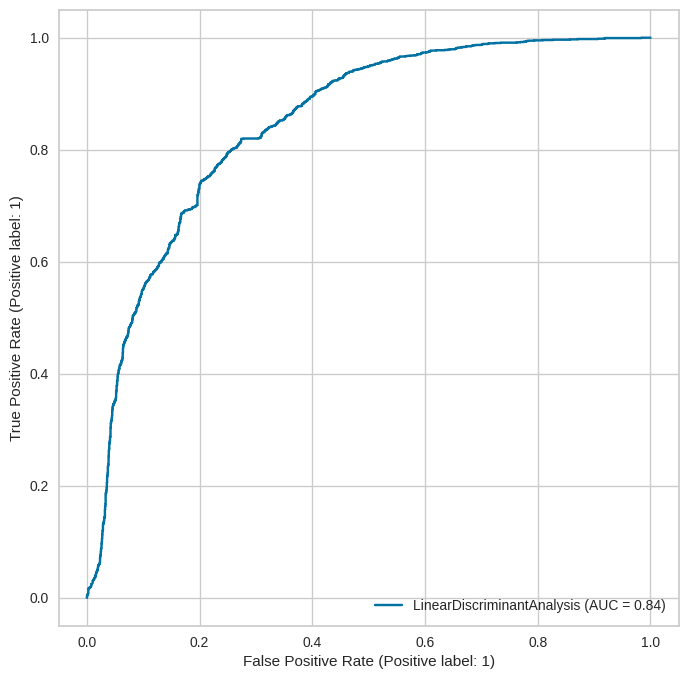

In [20]:
plt.figure(figsize=(8,8));
RocCurveDisplay.from_estimator(lda, X_test,y_test, pos_label=1, ax=plt.subplot());

Podem provar un model de regresio logistica que no assumeix cap tipus de distribucio en les dades 

In [21]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=10000)
param = {'penalty':['none', 'l2'], 'C':10**np.linspace(-3,3,21, endpoint=True)}
lr_gs =  GridSearchCV(lr,param,cv=10, n_jobs=-1, refit=True)
lr_gs.fit(X_train, y_train);
show_html(pd.DataFrame(lr_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

print(classification_report(lr_gs.predict(X_test), y_test,target_names=target_names))
results_df_lineal = save_results(lr_gs, X_test, y_test, 'LR', results_df_lineal)

/home/juli/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/juli/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/juli/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/juli/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/juli/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/juli/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarni

,params,mean_test_score,rank_test_score
0,"{'C': 0.001, 'penalty': 'none'}",0.578,1
23,"{'C': 1.9952623149688788, 'penalty': 'l2'}",0.578,1
24,"{'C': 3.981071705534969, 'penalty': 'none'}",0.578,1
25,"{'C': 3.981071705534969, 'penalty': 'l2'}",0.578,1
26,"{'C': 7.943282347242813, 'penalty': 'none'}",0.578,1


              precision    recall  f1-score   support

      Normal       0.84      0.58      0.69      3331
  Fraudulent       0.18      0.46      0.26       678

    accuracy                           0.56      4009
   macro avg       0.51      0.52      0.48      4009
weighted avg       0.73      0.56      0.62      4009



In [22]:
from sklearn.neighbors import KNeighborsClassifier
knn =  KNeighborsClassifier()
print(np.mean(cross_val_score(knn,X_train,y_train,cv=10)))

0.8458891296529674


In [23]:
param = {'n_neighbors':[15, 20, 25, 30], 
          'weights':['distance', 'uniform'], 
          'leaf_size':[30], #irrellevant
          'metric': ['l2', 'l1', 'cosine']}

knn_gs =  GridSearchCV(knn,param,cv=cv, n_jobs=-1)
knn_gs.fit(X_train, y_train);

In [24]:
show_html(pd.DataFrame(knn_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
12,"{'leaf_size': 30, 'metric': 'l1', 'n_neighbors': 25, 'weights': 'distance'}",0.855,1
10,"{'leaf_size': 30, 'metric': 'l1', 'n_neighbors': 20, 'weights': 'distance'}",0.855,2
8,"{'leaf_size': 30, 'metric': 'l1', 'n_neighbors': 15, 'weights': 'distance'}",0.855,3
14,"{'leaf_size': 30, 'metric': 'l1', 'n_neighbors': 30, 'weights': 'distance'}",0.855,4
2,"{'leaf_size': 30, 'metric': 'l2', 'n_neighbors': 20, 'weights': 'distance'}",0.850,5


In [25]:
i = 0
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.to_numpy(), feature_names=list(data.columns[:-1]),class_names=target_names, verbose=True, mode='classification')
exp = explainer.explain_instance(X_test.to_numpy()[i], knn_gs.predict_proba, num_features=6)
exp.show_in_notebook(show_table=True)

Intercept 0.2946670950287682
Prediction_local [0.72188857]
Right: 0.7248531953374759


In [26]:
print(classification_report(knn_gs.predict(X_test_n), y_test,target_names=target_names))
results_df_lineal = save_results(knn_gs, X_test_n, y_test, 'KNN', results_df_lineal)

              precision    recall  f1-score   support

      Normal       0.01      0.94      0.01        17
  Fraudulent       1.00      0.43      0.60      3992

    accuracy                           0.43      4009
   macro avg       0.50      0.68      0.31      4009
weighted avg       1.00      0.43      0.59      4009



In [27]:
results_df_lineal.sort_values(by=['test acc'], ascending=False)

,test acc,precision score (W),recall score (W),f1 score (W)
LDA,0.769,0.774,0.769,0.770
LR,0.562,0.531,0.562,0.508
KNN,0.428,0.723,0.428,0.261


### Metodes no linials

In [28]:
from sklearn.svm import SVC
from skopt import BayesSearchCV

In [29]:
param = {'C':10**np.linspace(-3,3,101)}

lsvc = SVC(max_iter=250000, random_state=0)
lsvc_gs = BayesSearchCV(lsvc,param,n_iter=niter, cv=cv, n_jobs=-1, refit=True, random_state=0)
lsvc_gs.fit(X_train, y_train)

BayesSearchCV(cv=5, estimator=SVC(max_iter=250000, random_state=0), n_iter=15,
              n_jobs=-1, random_state=0,
              search_spaces={'C': array([1.00000000e-03, 1.14815362e-03, 1.31825674e-03, 1.51356125e-03,
       1.73780083e-03, 1.99526231e-03, 2.29086765e-03, 2.63026799e-03,
       3.01995172e-03, 3.46736850e-03, 3.98107171e-03, 4.57088190e-03,
       5.24807460e-03, 6.02559586e-03, 6.91830971e-03...
       3.63078055e+01, 4.16869383e+01, 4.78630092e+01, 5.49540874e+01,
       6.30957344e+01, 7.24435960e+01, 8.31763771e+01, 9.54992586e+01,
       1.09647820e+02, 1.25892541e+02, 1.44543977e+02, 1.65958691e+02,
       1.90546072e+02, 2.18776162e+02, 2.51188643e+02, 2.88403150e+02,
       3.31131121e+02, 3.80189396e+02, 4.36515832e+02, 5.01187234e+02,
       5.75439937e+02, 6.60693448e+02, 7.58577575e+02, 8.70963590e+02,
       1.00000000e+03])})

In [30]:
show_html(pd.DataFrame(lsvc_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
6,{'C': 660.6934480075951},0.792,1
13,{'C': 72.44359600749891},0.789,2
5,{'C': 109.64781961431851},0.789,3
12,{'C': 54.954087385762485},0.788,4
14,{'C': 15.848931924611142},0.784,5


In [31]:
print(classification_report(lsvc_gs.predict(X_test), y_test,target_names=target_names))
results_df_no_lineal = save_results(lsvc_gs, X_test, y_test, 'SVC', results_df_no_lineal)

              precision    recall  f1-score   support

      Normal       0.95      0.76      0.84      2910
  Fraudulent       0.58      0.90      0.71      1099

    accuracy                           0.80      4009
   macro avg       0.77      0.83      0.78      4009
weighted avg       0.85      0.80      0.81      4009



In [32]:
from sklearn.neural_network import MLPClassifier

In [33]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

In [44]:
# sha provat amb X_train_n i X_test_n i no millora significativament, usarem X_train_s i X_test_s ja que el temps d'execucio es menor

# mlp = MLPClassifier(max_iter=1000, hidden_layer_sizes=5, activation='tanh', learning_rate_init=0.00001, solver='sgd', early_stopping=True, n_iter_no_change=15, random_state=0)
# print(np.mean(cross_val_score(mlp,X_train_n,y_train,cv=10)))

param = {'hidden_layer_sizes':[1, 2, 5], 
         'activation':['softmax', 'tanh'], 
         'learning_rate_init': [0.0001, 0.001]  }

mlp =  MLPClassifier(max_iter=100, solver='sgd', early_stopping=True, n_iter_no_change=10,random_state=10)
mlp_gs =  GridSearchCV(mlp,param,cv=cv, n_jobs=-1, refit=True)
mlp_gs.fit(X_train_n, y_train);
show_html(pd.DataFrame(mlp_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())
mlp.fit(X_train_n, y_train)
print(classification_report(mlp.predict(X_test), y_test,target_names=target_names))


0.5234101259931518


,params,mean_test_score,rank_test_score
9,"{'activation': 'tanh', 'hidden_layer_sizes': 2, 'learning_rate_init': 0.001}",0.730,1
7,"{'activation': 'tanh', 'hidden_layer_sizes': 1, 'learning_rate_init': 0.001}",0.682,2
11,"{'activation': 'tanh', 'hidden_layer_sizes': 5, 'learning_rate_init': 0.001}",0.671,3
10,"{'activation': 'tanh', 'hidden_layer_sizes': 5, 'learning_rate_init': 0.0001}",0.644,4
8,"{'activation': 'tanh', 'hidden_layer_sizes': 2, 'learning_rate_init': 0.0001}",0.531,5


              precision    recall  f1-score   support

      Normal       1.00      0.58      0.73      4009
  Fraudulent       0.00      0.00      0.00         0

    accuracy                           0.58      4009
   macro avg       0.50      0.29      0.37      4009
weighted avg       1.00      0.58      0.73      4009



In [35]:
print(classification_report(mlp_gs.predict(X_test), y_test,target_names=target_names))
results_df_no_lineal = save_results(mlp_gs, X_test, y_test, 'SVC', results_df_no_lineal)

              precision    recall  f1-score   support

      Normal       0.90      0.57      0.70      3653
  Fraudulent       0.07      0.35      0.12       356

    accuracy                           0.55      4009
   macro avg       0.49      0.46      0.41      4009
weighted avg       0.83      0.55      0.65      4009

